In [1]:
import os

import cv2
import onnx
from onnx2keras import onnx_to_keras
from onnx_pytorch import code_gen

from pytorchGenerator.model import Model
import numpy as np
import onnxruntime
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim

from matplotlib import pyplot as plt

In [2]:
def sigmoid(input):
    return 1 / (1 + np.exp(-input))

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4636991765303367344
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4178575360
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16399407635453007070
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:26:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [4]:
def onnx2Keras(path):
    onnx_model = onnx.load(path)
    model = onnx_to_keras(onnx_model, ['input_imgs', 'big_input_imgs', 'desire', 'traffic_convention', 'initial_state'],
                          name_policy='renumerate', change_ordering=False)
    model.save("models/keras")

Set model settings

In [5]:
# onnx2Keras("models/supercombo.onnx")

In [6]:
onnx_model = "models/supercombo.onnx"
modelType = "Keras"
# modelType = "Pytorch"

In [7]:
# if tf.test.is_built_with_cuda():
#     print("works")

Set variables

In [8]:
# tf.compat.v1.disable_v2_behavior()
plan_start_idx = 0
plan_end_idx = 4955

lanes_start_idx = plan_end_idx
lanes_end_idx = lanes_start_idx + 528

lane_lines_prob_start_idx = lanes_end_idx
lane_lines_prob_end_idx = lane_lines_prob_start_idx + 8

In [9]:
data = np.load('data/numpy.npz')

datasize = data['inputImgs'].shape[0]

inputImgs_data = data['inputImgs']
bigInputImgs_data = data['bigInputImgs']
desire_data = data['desire']
trafficConvention_data = data['trafficConvention']
initialState_data = data['initialState']
output_data = data['output']

trafficConventionShape = trafficConvention_data.shape
trafficConvention_data_inverted = trafficConvention_data[::, ::-1]
trafficConvention_data_ones = np.ones(trafficConventionShape)
trafficConvention_data_zeros = np.zeros(trafficConventionShape)

desireShape = desire_data.shape
desire_data_inverted = desire_data.astype(int)
desire_data_inverted = ~desire_data_inverted+2
desire_data_inverted = desire_data.astype(np.float32)
desire_data_ones = np.ones(desireShape)
desire_data_zeros = np.zeros(desireShape)
desire_data_0 = desire_data_zeros
desire_data_0[:,0] = 1
desire_data_1 = desire_data_zeros
desire_data_1[:,1] = 1
desire_data_2 = desire_data_zeros
desire_data_2[:,2] = 1
desire_data_3 = desire_data_zeros
desire_data_3[:,3] = 1
desire_data_4 = desire_data_zeros
desire_data_4[:,4] = 1
desire_data_5 = desire_data_zeros
desire_data_5[:,5] = 1
desire_data_6 = desire_data_zeros
desire_data_6[:,6] = 1
desire_data_7 = desire_data_zeros
desire_data_7[:,7] = 1

In [10]:
if modelType == "Keras":
    model = tf.keras.models.load_model("models/keras")
    result = model.predict(tf.data.Dataset.from_tensors({"input_imgs": inputImgs_data,
                                                         "big_input_imgs": bigInputImgs_data,
                                                         "desire": desire_data,
                                                         "traffic_convention": trafficConvention_data,
                                                         "initial_state": initialState_data}))
    result2 = model.predict(tf.data.Dataset.from_tensors({"input_imgs": inputImgs_data,
                                                          "big_input_imgs": bigInputImgs_data,
                                                          "desire": desire_data,
                                                          "traffic_convention": trafficConvention_data_inverted,
                                                          "initial_state": initialState_data}))
    result3 = model.predict(tf.data.Dataset.from_tensors({"input_imgs": inputImgs_data,
                                                          "big_input_imgs": bigInputImgs_data,
                                                          "desire": desire_data,
                                                          "traffic_convention": trafficConvention_data_ones,
                                                          "initial_state": initialState_data}))
    result4 = model.predict(tf.data.Dataset.from_tensors({"input_imgs": inputImgs_data,
                                                          "big_input_imgs": bigInputImgs_data,
                                                          "desire": desire_data,
                                                          "traffic_convention": trafficConvention_data_zeros,
                                                          "initial_state": initialState_data}))
    result5 = model.predict(tf.data.Dataset.from_tensors({"input_imgs": inputImgs_data,
                                                         "big_input_imgs": bigInputImgs_data,
                                                         "desire": desire_data_inverted,
                                                         "traffic_convention": trafficConvention_data,
                                                         "initial_state": initialState_data}))
    result6 = model.predict(tf.data.Dataset.from_tensors({"input_imgs": inputImgs_data,
                                                         "big_input_imgs": bigInputImgs_data,
                                                         "desire": desire_data_ones,
                                                         "traffic_convention": trafficConvention_data,
                                                         "initial_state": initialState_data}))
    result7 = model.predict(tf.data.Dataset.from_tensors({"input_imgs": inputImgs_data,
                                                         "big_input_imgs": bigInputImgs_data,
                                                         "desire": desire_data_zeros,
                                                         "traffic_convention": trafficConvention_data,
                                                         "initial_state": initialState_data}))
    result8 = model.predict(tf.data.Dataset.from_tensors({"input_imgs": inputImgs_data,
                                                          "big_input_imgs": bigInputImgs_data,
                                                          "desire": desire_data_0,
                                                          "traffic_convention": trafficConvention_data,
                                                          "initial_state": initialState_data}))
    result9 = model.predict(tf.data.Dataset.from_tensors({"input_imgs": inputImgs_data,
                                                          "big_input_imgs": bigInputImgs_data,
                                                          "desire": desire_data_1,
                                                          "traffic_convention": trafficConvention_data,
                                                          "initial_state": initialState_data}))
    result10 = model.predict(tf.data.Dataset.from_tensors({"input_imgs": inputImgs_data,
                                                          "big_input_imgs": bigInputImgs_data,
                                                          "desire": desire_data_2,
                                                          "traffic_convention": trafficConvention_data,
                                                          "initial_state": initialState_data}))
    result11 = model.predict(tf.data.Dataset.from_tensors({"input_imgs": inputImgs_data,
                                                          "big_input_imgs": bigInputImgs_data,
                                                          "desire": desire_data_3,
                                                          "traffic_convention": trafficConvention_data,
                                                          "initial_state": initialState_data}))
    result12 = model.predict(tf.data.Dataset.from_tensors({"input_imgs": inputImgs_data,
                                                          "big_input_imgs": bigInputImgs_data,
                                                          "desire": desire_data_4,
                                                          "traffic_convention": trafficConvention_data,
                                                          "initial_state": initialState_data}))
    result13 = model.predict(tf.data.Dataset.from_tensors({"input_imgs": inputImgs_data,
                                                          "big_input_imgs": bigInputImgs_data,
                                                          "desire": desire_data_5,
                                                          "traffic_convention": trafficConvention_data,
                                                          "initial_state": initialState_data}))
    result14 = model.predict(tf.data.Dataset.from_tensors({"input_imgs": inputImgs_data,
                                                          "big_input_imgs": bigInputImgs_data,
                                                          "desire": desire_data_6,
                                                          "traffic_convention": trafficConvention_data,
                                                          "initial_state": initialState_data}))
    result15 = model.predict(tf.data.Dataset.from_tensors({"input_imgs": inputImgs_data,
                                                           "big_input_imgs": bigInputImgs_data,
                                                           "desire": desire_data_7,
                                                           "traffic_convention": trafficConvention_data,
                                                           "initial_state": initialState_data}))
elif modelType == "Pytorch":
    model = torch.load('models/supercombo.pt')
    model.eval()

    result = model(torch.from_numpy(inputImgs_data), torch.from_numpy(bigInputImgs_data),
                   torch.from_numpy(desire_data), torch.from_numpy(trafficConvention_data),
                   torch.from_numpy(initialState_data))
    result = result.detach().numpy()

1/1 [==============================] - 0s 472ms/step


In [11]:
def calculateAccuracy(result, pb, type):
    lane_lines_prob = sigmoid(result[:, lane_lines_prob_start_idx + 1:lane_lines_prob_end_idx:2])
    probability = (lane_lines_prob >= pb).astype(int)
    accuracy = np.sum(probability == output_data) / (len(output_data) * len(output_data[0]))
    print("Accuracy on " + type + " examples: {}%".format(accuracy * 100))
    return lane_lines_prob

In [12]:
probabilityPoint = 0.7

lane_lines_prob = calculateAccuracy(result, probabilityPoint, "default")
lane_lines_prob2 = calculateAccuracy(result2, probabilityPoint, "Inverted Traffic Convention")
lane_lines_prob3 = calculateAccuracy(result3, probabilityPoint, "Ones Traffic Convention")
lane_lines_prob4 = calculateAccuracy(result4, probabilityPoint, "Zeros Traffic Convention")
lane_lines_prob5 = calculateAccuracy(result5, probabilityPoint, "Inverted Desire")
lane_lines_prob6 = calculateAccuracy(result6, probabilityPoint, "Ones Desire")
lane_lines_prob7 = calculateAccuracy(result7, probabilityPoint, "Zeros Desire")
lane_lines_prob8 = calculateAccuracy(result8, probabilityPoint, "1 on index 0")
lane_lines_prob9 = calculateAccuracy(result9, probabilityPoint, "1 on index 1")
lane_lines_prob10 = calculateAccuracy(result10, probabilityPoint, "1 on index 2")
lane_lines_prob11 = calculateAccuracy(result11, probabilityPoint, "1 on index 3")
lane_lines_prob12 = calculateAccuracy(result12, probabilityPoint, "1 on index 4")
lane_lines_prob13 = calculateAccuracy(result13, probabilityPoint, "1 on index 5")
lane_lines_prob14 = calculateAccuracy(result14, probabilityPoint, "1 on index 6")
lane_lines_prob15 = calculateAccuracy(result15, probabilityPoint, "1 on index 7")

Accuracy on default examples: 94.82323232323232%
Accuracy on Inverted Traffic Convention examples: 95.83333333333334%
Accuracy on Ones Traffic Convention examples: 94.94949494949495%
Accuracy on Zeros Traffic Convention examples: 95.83333333333334%
Accuracy on Inverted Desire examples: 94.82323232323232%
Accuracy on Ones Desire examples: 50.75757575757576%
Accuracy on Zeros Desire examples: 50.75757575757576%
Accuracy on 1 on index 0 examples: 50.75757575757576%
Accuracy on 1 on index 1 examples: 50.75757575757576%
Accuracy on 1 on index 2 examples: 50.75757575757576%
Accuracy on 1 on index 3 examples: 50.75757575757576%
Accuracy on 1 on index 4 examples: 50.75757575757576%
Accuracy on 1 on index 5 examples: 50.75757575757576%
Accuracy on 1 on index 6 examples: 50.75757575757576%
Accuracy on 1 on index 7 examples: 50.75757575757576%


In [13]:
def plotResults(prob, x, number, label):
    y = np.array(prob)
    plt.plot(x, y, label=label)
    if number == 0:
        plt.title("left far")
    if number == 1:
        plt.title("left near")
    if number == 2:
        plt.title("right near")
    if number == 3:
        plt.title("right far")

Traffic Convention


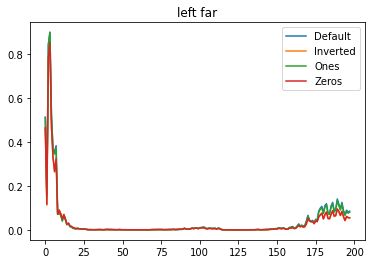

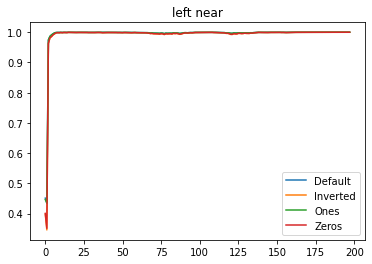

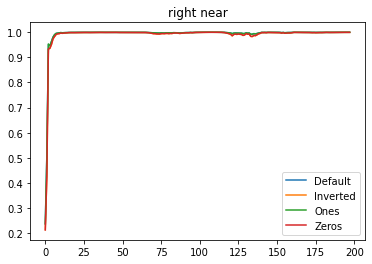

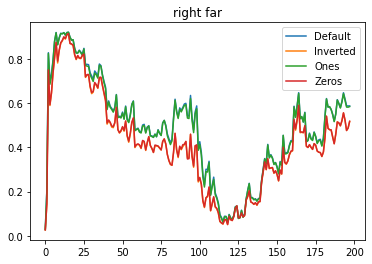

Desire


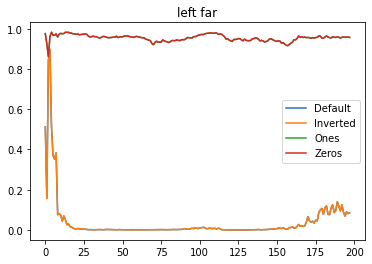

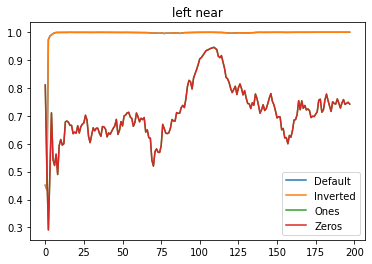

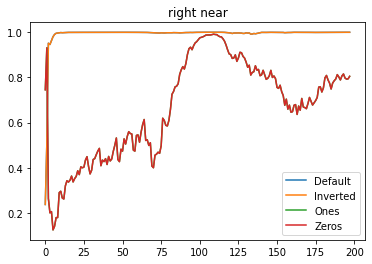

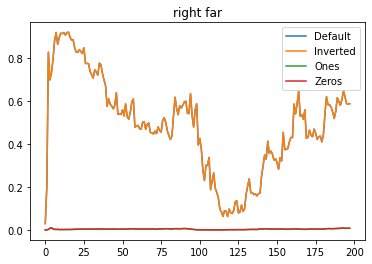

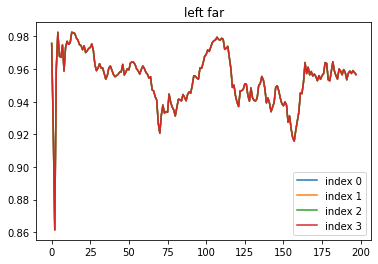

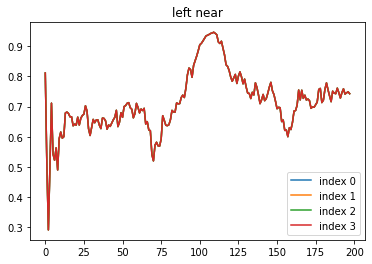

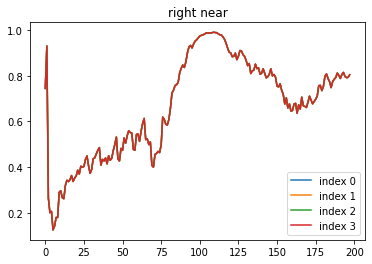

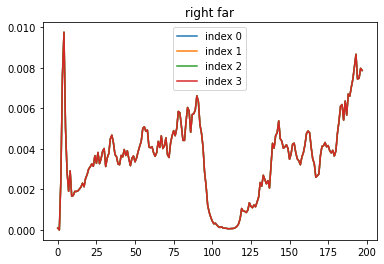

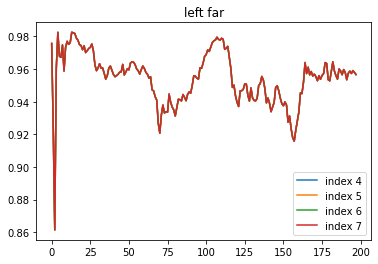

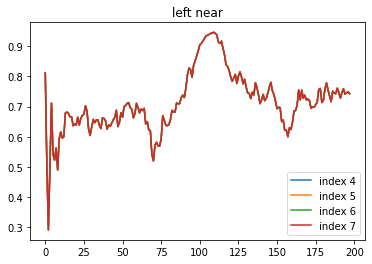

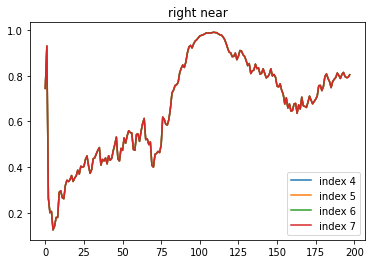

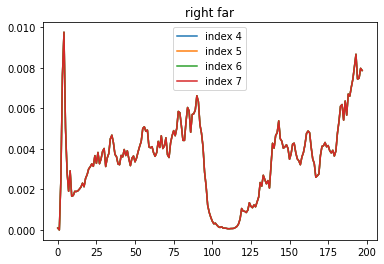

In [14]:
x = np.arange(0, datasize)
print("Traffic Convention")
for n in range(4):
    plotResults(np.column_stack(lane_lines_prob)[n], x, n, "Default")
    plotResults(np.column_stack(lane_lines_prob2)[n], x, n, "Inverted")
    plotResults(np.column_stack(lane_lines_prob3)[n], x, n, "Ones")
    plotResults(np.column_stack(lane_lines_prob4)[n], x, n, "Zeros")
    plt.legend()
    plt.show()

print("Desire")
for n in range(4):
    plotResults(np.column_stack(lane_lines_prob)[n], x, n, "Default")
    plotResults(np.column_stack(lane_lines_prob5)[n], x, n, "Inverted")
    plotResults(np.column_stack(lane_lines_prob6)[n], x, n, "Ones")
    plotResults(np.column_stack(lane_lines_prob7)[n], x, n, "Zeros")
    plt.legend()
    plt.show()

for n in range(4):
    plotResults(np.column_stack(lane_lines_prob8)[n], x, n, "index 0")
    plotResults(np.column_stack(lane_lines_prob9)[n], x, n, "index 1")
    plotResults(np.column_stack(lane_lines_prob10)[n], x, n, "index 2")
    plotResults(np.column_stack(lane_lines_prob11)[n], x, n, "index 3")
    plt.legend()
    plt.show()

for n in range(4):
    plotResults(np.column_stack(lane_lines_prob12)[n], x, n, "index 4")
    plotResults(np.column_stack(lane_lines_prob13)[n], x, n, "index 5")
    plotResults(np.column_stack(lane_lines_prob14)[n], x, n, "index 6")
    plotResults(np.column_stack(lane_lines_prob15)[n], x, n, "index 7")
    plt.legend()
    plt.show()